In [8]:
import pandas as pd
import numpy as np

df = pd.read_parquet('../data/training_data/traindf_100km.pq')
col_map = dict(zip(df.columns, range(len(df.columns))))
df.columns

Index(['fco2rec_uatm', 'sst_cci', 'sss_cci', 'pppp_hpa', 'woa_sss',
       'ncep_slp_hpa', 'dist_to_land_km', 'chl_globcolour', 'temp_soda',
       'salt_soda', 'mld_dens_soda', 'ssh_adt', 'ssh_sla', 'ice_cci',
       'day_of_year', 'year', 'lon', 'lat'],
      dtype='object')

In [9]:
from fco2dataset.ucruise import filter_nans
num_bins = df.index.get_level_values('bin').unique().shape[0]
num_segments = df.index.get_level_values('segment').unique().shape[0]
ds = df.values.reshape(len(df.columns), num_segments, num_bins)
y  = ds[0]#= df.fco2rec_uatm.values.reshape(num_segments, num_bins)
salt_soda = ds[col_map['salt_soda']]
sss_cci = ds[col_map['sss_cci']]
mask = np.isnan(sss_cci)
ds[col_map['sss_cci'], mask] = salt_soda[np.isnan(sss_cci)]
ds = ds[:, :, :-1]
y = y[:, :-1]
X, y = filter_nans(ds, y, ['sst_cci', 'sss_cci', 'chl_globcolour'], col_map)
X.shape, y.shape


Number of samples after filtering:  85202


((3, 85202, 64), (85202, 64))

In [ ]:

from fco2dataset.ucruise import filter_nans
from scipy.ndimage import gaussian_filter1d
# read npz file
ds = np.load('../data/training_data/trainds_100km.npy')
print(ds.shape)
y = ds[0]
# ESA-CCI > SODA 
# merge salt_soda and sss_cci, where sss_cci has priority, use salt_soda where sss_cci is nan
salt_soda = ds[col_map['salt_soda']]
sss_cci = ds[col_map['sss_cci']]
mask = np.isnan(sss_cci)
ds[col_map['sss_cci'], mask] = salt_soda[np.isnan(sss_cci)]
# salinity = ds[col_map['sss_cci']]
# ds[col_map['sss_cci']] = gaussian_filter1d(salinity, 1, axis=1)



# print(salinity[0])
# print(salinity2[0])
# ds[col_map['sss_cci']] = salinity2
X, y = filter_nans(ds[:, :, :-1], y[:, :-1], ['sst_cci', 'sss_cci', 'chl_globcolour', 'mld_dens_soda'], col_map)
X.shape, y.shape

(18, 117337, 65)
Number of samples after filtering:  85202


((4, 85202, 64), (85202, 64))

In [7]:
import numpy as np
print(np.apply_along_axis(lambda x: np.isnan(x).all(), 1, y).sum())

4236


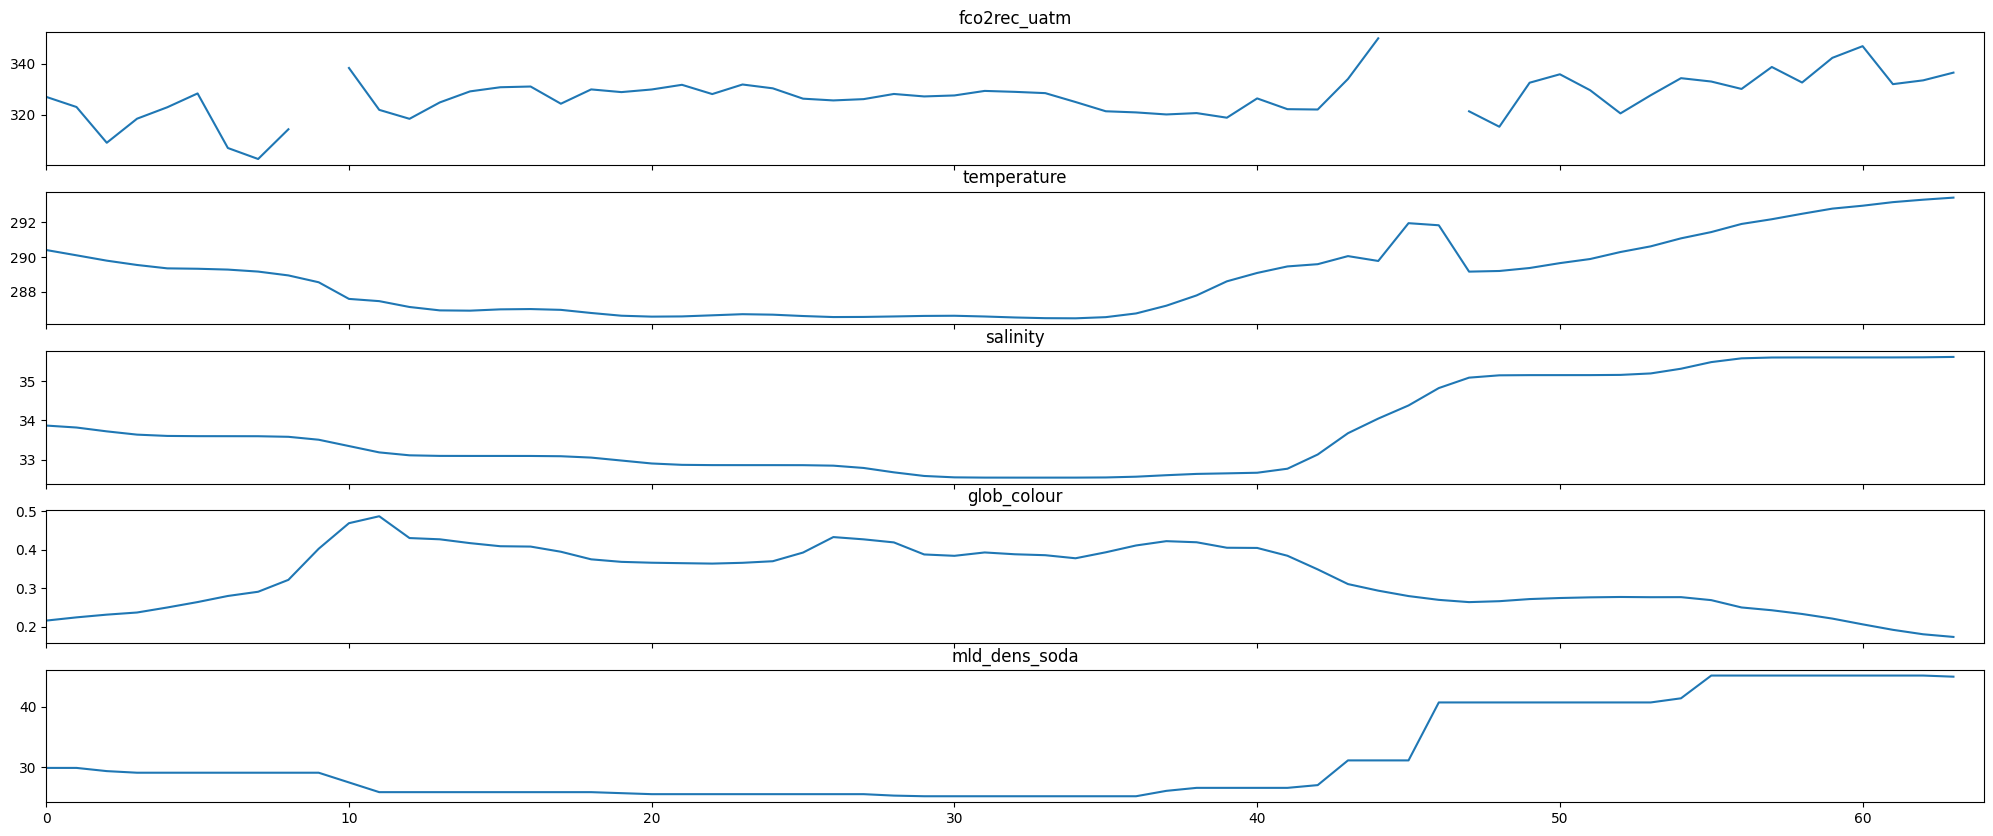

In [15]:
from fco2dataset.ucruise import plot_segment
import matplotlib.pyplot as plt



plot_segment(X, y, ['fco2rec_uatm', 'temperature', 'salinity', 'glob_colour', 'mld_dens_soda'], 11)
# print(X[0, 0, :])

In [9]:
np.where((X < 0))

(array([1, 1, 1, ..., 1, 1, 1], shape=(1284,)),
 array([81421, 81421, 81421, ..., 84870, 84870, 84870], shape=(1284,)),
 array([34, 35, 36, ...,  0,  1,  2], shape=(1284,)))

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
# import wandb
from tqdm import tqdm
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMScheduler, UNet1DModel
from fco2models.utraining import train_diffusion
from torch.utils.data import TensorDataset

# fix random seed

np.random.seed(0)
torch.manual_seed(0)

print(X.shape, y[np.newaxis].shape)
assert np.isnan(X).sum() == 0
n_samples = X.shape[1]
n_dims = X.shape[2]
# print(y[:16])
ds = np.zeros((n_samples, X.shape[0] + 1, n_dims))

# REMOVE AFTER TESTING
# replace all features with random noise
# ds[:, 1:, :] = np.random.randn(*ds[:, 1:, :].shape)
# # replace target with linear combination of features
# ds[:, 0, :] = np.sum(ds[:, 1:, :], axis=1)
# y = np.log(y + 1)
# X = np.log(X + 2)
ds[:, 0, :] = (y - np.nanmean(y)) / np.nanstd(y)
for i in range(X.shape[0]):
    ds[:, i + 1, :] = (X[i] - X[i].mean()) / X[i].std()

print(ds.shape)
print(np.nanmean(ds[:, 0, :]), np.nanstd(ds[:, 0, :]))
# shuffle
np.random.shuffle(ds)
# split into training and validation
train_ds = ds[:int(0.9 * n_samples)]
val_ds = ds[int(0.9 * n_samples):]
train_dataset = TensorDataset(torch.from_numpy(train_ds))
val_dataset = TensorDataset(torch.from_numpy(val_ds))

(4, 85202, 64) (1, 85202, 64)
(85202, 5, 64)
6.48592236946607e-07 0.9999999059692841


In [11]:
timestep_dim = 16
# model = UNet1DModel(sample_size=64, 
#                     in_channels= 4 + timestep_dim, 
#                     out_channels=1)
down_block_types = ["DownBlock1D", "DownBlock1D"]
up_block_types = [ "UpBlock1D", "UpBlock1D"]
model_params = {
    "sample_size": 64,
    "in_channels": timestep_dim + ds.shape[1] + 1,
    "out_channels": 1,
    "layers_per_block": 3,
    # "block_out_channels": (64, 128),
    # "down_block_types": down_block_types,
    # "up_block_types": up_block_types,
    # "act_fn": "sigmoid"
}
model = UNet1DModel(**model_params)
batch_size = 128
num_epochs = 5
lr = 1e-3
timesteps = 500
optimizer = optim.AdamW(model.parameters(), lr=lr)
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
lr_scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=num_epochs * len(train_dataloader))
noise_scheduler = DDPMScheduler(num_train_timesteps=timesteps, beta_schedule='squaredcos_cap_v2', clip_sample_range=5.0)
model, train_losses, val_losses = train_diffusion(model,
                                                  num_epochs=num_epochs, 
                                                  optimizer=optimizer, 
                                                  lr_scheduler=lr_scheduler, 
                                                  noise_scheduler=noise_scheduler, 
                                                  train_dataloader=train_dataloader,
                                                  val_dataloader=val_dataloader)

Training on cuda


Epoch 1/5: 100%|██████████| 600/600 [01:09<00:00,  8.62it/s, Loss=0.172]


Epoch 1 Loss: 0.237132
Total gradient norm: 0.3748686900607643


AttributeError: 'list' object has no attribute 'to'

In [118]:
# save the model
torch.save(model.state_dict(), '../models/first/model_1d.pt')
noise_scheduler.save_config('../models/first')
# save also model hyperparameters
import json
with open('../models/first/1d_params.json', 'w') as f:
    json.dump({'batch_size': batch_size, 
               'num_epochs': num_epochs, 
               'lr': lr,
               'timesteps': timesteps,
               'model_params': model_params}, f)
# wandb.finish()
# print('done')

In [15]:
timestep_dim = 16
model_params = {
    "sample_size": 64,
    "in_channels": timestep_dim + ds.shape[1] + 1,
    "out_channels": 1,
    "layers_per_block": 3,
}
# load the model
model = UNet1DModel(**model_params)
model.load_state_dict(torch.load('../models/model1_100.pt'))
model.eval()
# random model
random_model = UNet1DModel(**model_params)
random_model.eval()
# load the scheduler
# noise_scheduler_config = DDPMScheduler.load_config('../models/first/scheduler_config.json', local_files_only=True)
noise_scheduler = DDPMScheduler(num_train_timesteps=500, beta_schedule='squaredcos_cap_v2', clip_sample_range=5.0)
# noise_scheduler = DDPMScheduler(**noise_scheduler_config)
# load also model hyperparameters
import json
with open('../models/first/1d_model_params.json', 'r') as f:
    model_params = json.load(f)

In [16]:
# find sample in validation dataset with highest mean and std
print(val_ds[:, 0, :].shape)
fco2val = val_ds[:, 0, :]
print(np.apply_along_axis(lambda row: np.isnan(row).all(), 1, fco2val).any())
means = np.nanmean(fco2val, axis=1)
stds = np.nanstd(fco2val, axis=1)
idx1 = np.nanmax(means)
idx2 = np.nanmax(stds)
idx1, idx2

(8521, 64)
False


(np.float64(8.563765900475639), np.float64(7.22348056229374))

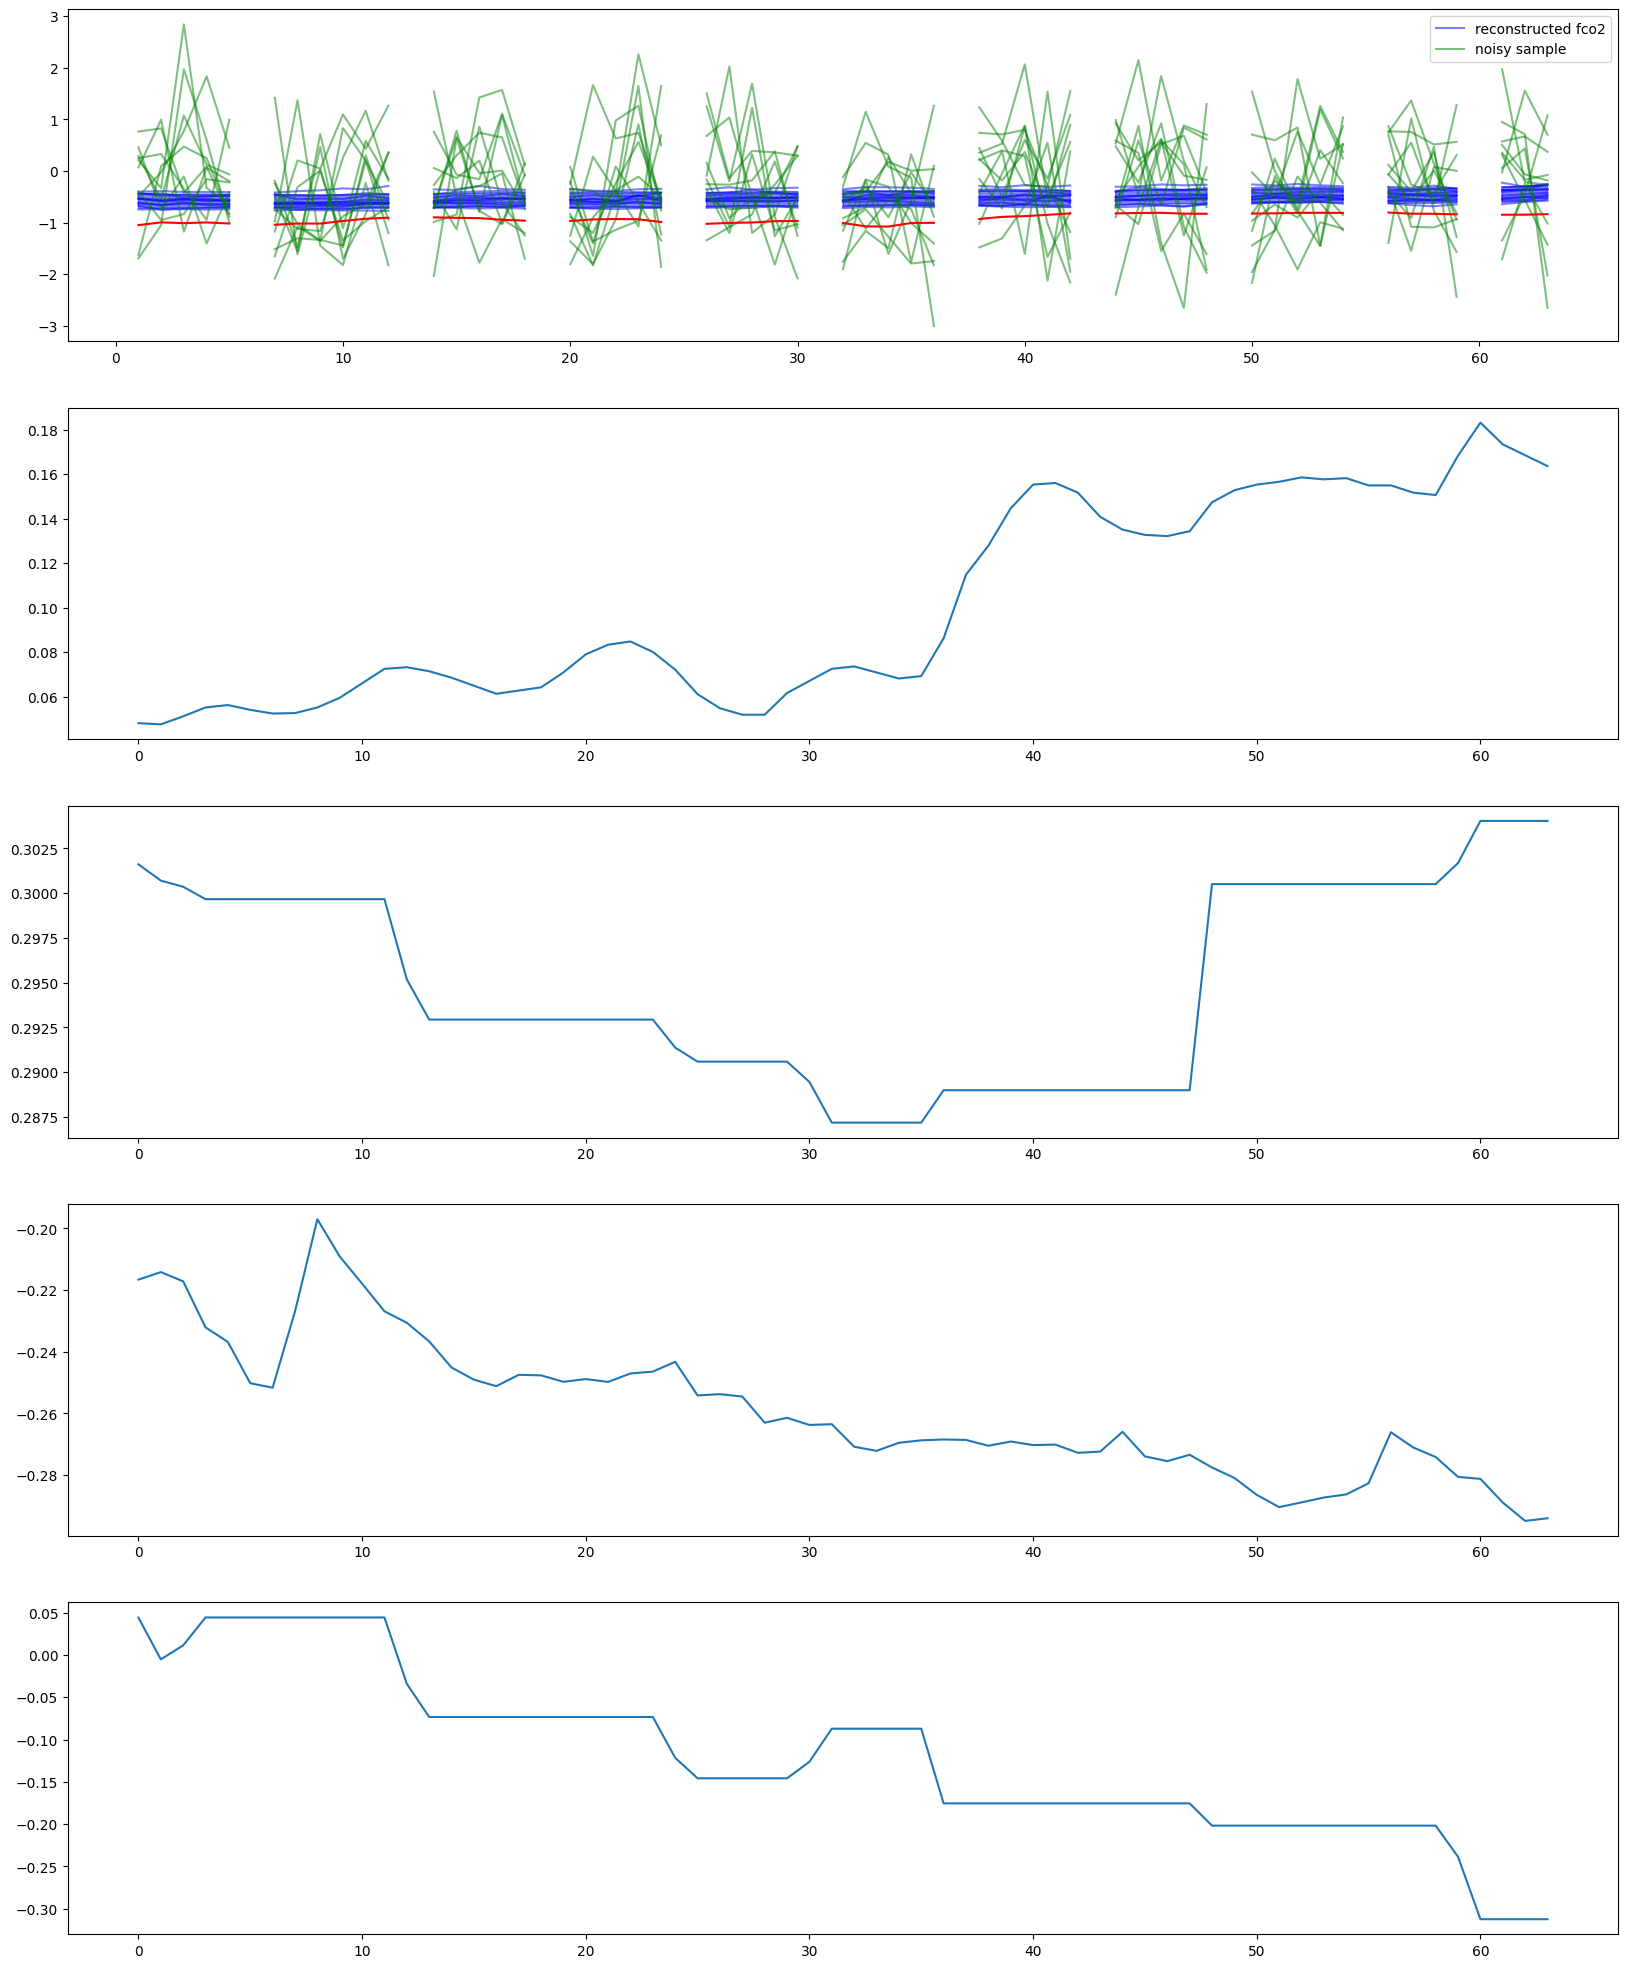

In [23]:
ix = 100
sample = torch.from_numpy(val_ds[ix, 0:1, :]).float()
nan_sample = torch.where(torch.isnan(sample), torch.zeros_like(sample), sample)
context = torch.from_numpy(val_ds[ix, 1:, :]).float()
# add nan mask to the context
nan_mask = ~torch.isnan(sample)
context = torch.cat([context, nan_mask.float()], dim=0)
timesteps = torch.tensor([400])
# sample 100 times and plot the distribution of reconstructed fco2
reconstructed_fco2s = []
reconstructed_noise = []
random = []
noisy_samples = []
model.to('cpu')
for _ in range(100):
    noise = torch.randn_like(nan_sample)
    noisy_sample = noise_scheduler.add_noise(nan_sample, noise, timesteps)
    input = torch.cat([noisy_sample, context], dim=0).unsqueeze(0)
    with torch.no_grad():
        output = model(sample=input, timestep=timesteps)
        random_output = random_model(sample=input, timestep=timesteps)

    # reconstructed_fco2s.append(output[0].numpy().flatten())
    # reconstructed_fco2 = noise_scheduler.step(output[0], timesteps, )
    nan_fco2 = noise_scheduler.step(output[0], timesteps.item(), noisy_sample).pred_original_sample
    rec_fco2 = torch.where(nan_mask, nan_fco2, np.nan)
    reconstructed_fco2s.append(rec_fco2.numpy().flatten())
    nan_noisy_sample = torch.where(~nan_mask, torch.nan, noisy_sample)
    noisy_samples.append(nan_noisy_sample.numpy().flatten())
    random.append(random_output[0].numpy().flatten())

reconstructed_fco2s = np.array(reconstructed_fco2s)
random = np.array(random)
noisy_samples = np.array(noisy_samples)
fig, axs = plt.subplots(5, 1, figsize=(20, 5*5))
line01 = axs[0].plot(reconstructed_fco2s.T[:,:10], color='blue', alpha=0.5)
# plot devations from the mean
axs[0].fill_between(np.arange(0, 64), reconstructed_fco2s.mean(axis=0) - reconstructed_fco2s.std(axis=0),
                 reconstructed_fco2s.mean(axis=0) + reconstructed_fco2s.std(axis=0), color='blue', alpha=0.5)
line02 = axs[0].plot(noisy_samples.T[:,:10], color='green', alpha=0.5)
# plt.plot(random.T, color='green', alpha=0.05)
# plt.plot(reconstructed_fco2s.mean(axis=0), label='reconstructed fco2')
# plt.plot(random.mean(axis=0), label='random diffusion')
axs[0].plot(sample.flatten(), label='true fco2', color='red')
axs[0].legend(handles=[line01[0], line02[0]], labels=['reconstructed fco2', 'noisy sample'])
axs[1].plot(context[0].numpy(), label='temperature')
axs[2].plot(context[1].numpy(), label='salinity')
axs[3].plot(context[2].numpy(), label='glob colour')
axs[4].plot(context[3].numpy(), label='mld dens soda')
plt.show()
# print(reconstructed_fco2s

In [20]:
ix = 200
fco2 = torch.from_numpy(val_ds[ix, 0:1, :]).float().view(1, 1, -1)
nan_sample = torch.where(torch.isnan(fco2), torch.zeros_like(fco2), fco2)
context = torch.from_numpy(val_ds[ix, 1:, :]).float().view(1, 4, -1)
print(context.shape)
print(sample.shape)

n_samples = 10
samples = []
for ix in range(n_samples):
    print(ix)
    sample = torch.randn(1, 1, 64)
    for i, t in enumerate(noise_scheduler.timesteps):
        mask = torch.ones_like(sample).bool()
        # concat noise, context and mask
        sample_context = torch.cat([sample, context, mask], dim=1)
    
        # Get model pred
        with torch.no_grad():
            residual = model(sample_context, t, return_dict=False)[0]
    
        # Update sample with step
        sample = noise_scheduler.step(residual, t, sample).prev_sample
    samples.append(sample)



# plot final samples

torch.Size([1, 4, 64])
torch.Size([1, 64])
0
1
2
3
4
5
6
7
8
9


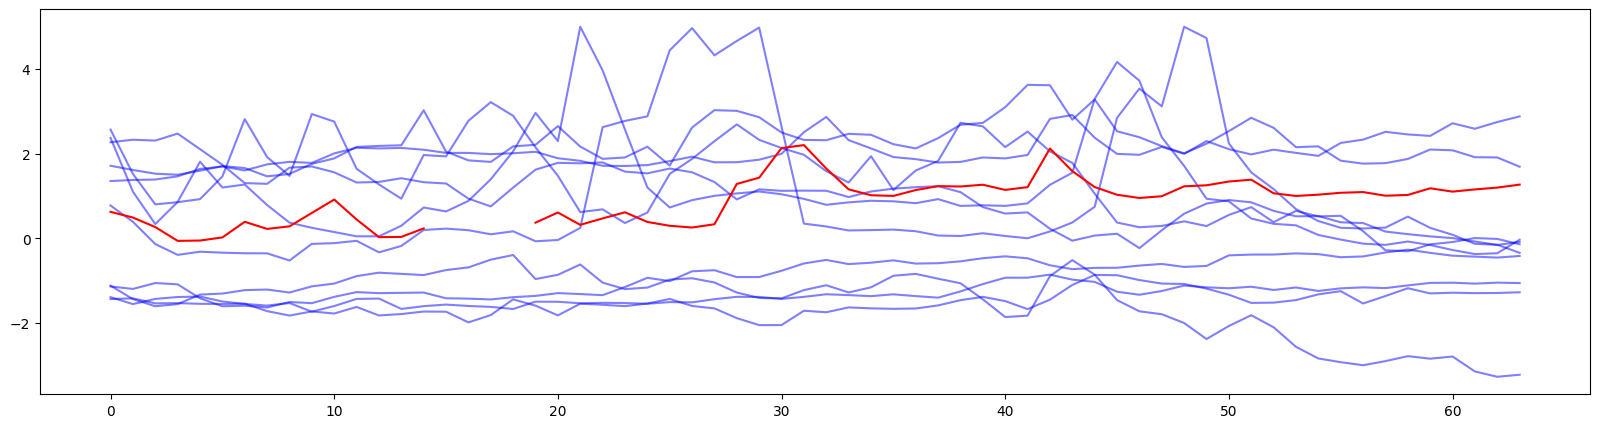

In [21]:
samples = torch.cat(samples, dim=0)
samples = samples.squeeze(1).detach().numpy()
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
axs.plot(samples.T, color='blue', alpha=0.5)
axs.plot(fco2.flatten(), label='true fco2', color='red')